## Walking Detection on Passive Data Collection

This notebook will explore whether if we can differentiate passive data to know whether a user is actually walking during the mPower passive walking tests. The design will be based on fitting a Random Forest Model on the active data, using the grouped records walking and balance data. We will use isWalking as the target variable, anntotating walking as 1 and balance as 0. Then using that fitted model, we will try to predict a probability on the passive data, to see the prediction probability of the Random Forest model. Afterwards, we will fact check the model's performance on the passive data by visualizing some of the records with high walking or balance model propensity scores and see whether the our prediction captures any signal on detecting passive signal data that indicates on a user that is not actually walking during the tests. 

### Library Imports

In [1]:
# Library Imports
import sys
import warnings
sys.path.append("../src/pipeline")
from utils import query_utils as query
from utils import gait_features_utils as gproc
import synapseclient as sc
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Modelling Library Imports
from sklearn.datasets import load_digits
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier)
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import sklearn.metrics as metrics
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import IterativeImputer


# magic commands
%matplotlib inline
%load_ext autoreload
%autoreload 2

# extra commands
sns.set_style("darkgrid")
sns.set_context("paper")
warnings.simplefilter("ignore")

### Global Variables

In [2]:
GROUPED_RID = "syn21678696"
syn = sc.login()

Welcome, aryton tediarjo!



INFO:synapseclient_default:Welcome, aryton tediarjo!



In [3]:
# helper function to visualize signal data
def visualize_signal_helper(data):
    num_sample = 1
    for filepath in data["walk_motion.json_pathfile"]:
        print("\n###################### SAMPLE %s ################################################"%num_sample)
        print("################################################################################")
        u_acc = gf.get_sensor_data(filepath, "userAcceleration")
        gyro = gf.get_sensor_data(filepath, "rotationRate")
        location = 0
        fig, axes = plt.subplots(1,3, sharey = True, figsize=(20,5))
        for i in ["x", "y", "z"]:
            u_acc[i].plot(ax=axes[location])
            axes[location].set_title("%s User Acceleration"%i)
            axes[location].axhline(y = 0, color='r', linestyle = ":")
            location += 1
        plt.show()
        location = 0
        fig, axes = plt.subplots(1,3, sharey = True, figsize=(20,5))
        for i in ["x", "y", "z"]:
            gyro[i].plot(ax=axes[location])
            axes[location].set_title("%s Gyroscope"%i)
            axes[location].axhline(y = 0, color='r', linestyle = ":")
            location += 1
        plt.show()
        num_sample += 1

# get results dataframe for predictive results
def get_results_dataframe(X_test, y_test, *models):
    data_dict = {}
    data_dict["model"] = []
    data_dict["parameter"] = []
    data_dict["roc-auc-cv"] = []
    data_dict["roc-auc-test"] = []
    data_dict["log-loss-test"] = []
    data_dict["f1-score-test"] = []
    for model in models:
        try:
            data_dict["model"].append(type(model.best_estimator_["classifier"]).__name__)
            data_dict["parameter"].append(model.best_params_)
            data_dict["roc-auc-cv"].append(model.best_score_)
        except:
            data_dict["model"].append(type(model).__name__)
            data_dict["parameter"].append(np.NaN)
            data_dict["roc-auc-cv"].append(np.NaN)
        y_true, y_pred = y_test, model.predict(X_test)
        data_dict["roc-auc-test"].append(metrics.roc_auc_score(y_true, y_pred))
        data_dict["log-loss-test"].append(metrics.log_loss(y_true, y_pred))
        data_dict["f1-score-test"].append(metrics.f1_score(y_true, y_pred))
    data = pd.DataFrame(data_dict)
    return data

### Retrieve Data From Synapse

Similar to previous analysis, due to the sparsity of the aggregated dataset, only columns that has less than 20% null values will be considered for calculation and model fitting. 

In [4]:
## dirty way of getting some preliminary data
data = query.get_file_entity(syn, GROUPED_RID)
data = data[[feat for feat in data.columns 
             if ("window" not in feat) 
             and ("steps" not in feat) 
             and ("consec_zero_cadence" not in feat)]]

# filter datasets
active_data = data[(data["age"] > 0) & 
            (data["table_version"] != "MPOWER_PASSIVE")]

passive_data = data[(data["age"] > 0) & 
            (data["table_version"] == "MPOWER_PASSIVE")]

# clean sparse feature
active_data = active_data[active_data.columns[active_data.isnull().mean() < 0.2]]

# clean sparse feature
passive_data = passive_data[passive_data.columns[passive_data.isnull().mean() < 0.2]]

# cols of choice
metadata_cols = ["test_type", "phoneInfo", "age", "gender", "table_version", "appVersion", "createdOn", "class"]
feat_cols = [feat for feat in active_data.columns if (feat not in metadata_cols)]

# subset data and map test class
train = active_data[feat_cols].drop(["recordId", "healthCode"], axis = 1)
target = active_data["test_type"].map({"walking":1, "balance":0})

In [5]:
## number of user of balance-walking (walking: 1, balance: 0)
target.value_counts()

1    87767
0    87541
Name: test_type, dtype: int64

### Model Fitting

In the model fitting, we will be using a RF model with 1000 trees, we will also use bootstrapping to ensure that the model is properly generalized and not biased to any subset of the feature dataset.  

In terms of null values, as this is just an MVP on how we can use walk and balance data to infer passive gait data, we will only use median imputations as it is a reliable imputation methods that is fast and not susceptible to outliers.

In [6]:
# Create raw model with 1000 estimators
model = RandomForestClassifier(n_estimators = 100, 
                               random_state = 100)

# A simple median imputation on feature sets
imp_median = SimpleImputer(missing_values=np.nan, 
                           strategy='median')


# split train test split
X_train, X_test, y_train, y_test = train_test_split(train, target, 
                                                    test_size = 0.20,
                                                    random_state = 100)

# median imputation on training sets
imp_median.fit(X_train)
X_train = imp_median.transform(X_train)
model.fit(X_train, y_train)

# Transform data based on imputer on test sets
X_test = imp_median.transform(X_test)
y_pred = model.predict(X_test)

### Performance Results

In assessing performance results, we would want to know the AUC, F1-Score and LogLoss score. In this case, <b> minimizing the log loss score </b> is the most reliable metrics as it has the capability to assess whether the model is capable on assigning a high propensity score on a target given their state (score of resting given a resting label, or vice versa). This is due to the reason our model is being implemented to a unsupervised learning task of inferring walking to users of passive gait test.

In [7]:
get_results_dataframe(X_test, y_test, model)

,model,parameter,roc-auc-cv,roc-auc-test,log-loss-test,f1-score-test
0,RandomForestClassifier,NaN,NaN,0.973567,0.91318,0.973692


Our results on predicting whether a person is doing a balance or walking test resulted in a very high AUC score in the test sets, and the log-loss score is extremely low, meaning that the model can create good separation in classifying users that are doing their balance or walking tests. 

### Probability Distributions

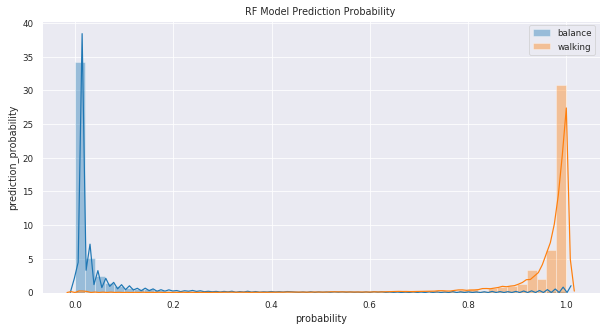

In [8]:
# get probability dataframe
proba = pd.DataFrame({"probability": model.predict_proba(X_test)[:,1], })
proba["is_walking"] = y_test.reset_index(drop = True)

# plot probability distribution
plt.figure(figsize = (10,5))
sns.distplot(proba["probability"][proba["is_walking"] == 0], label = "balance")
sns.distplot(proba["probability"][proba["is_walking"] == 1], label = "walking")
plt.legend()
plt.ylabel("prediction_probability")
plt.title("RF Model Prediction Probability")
plt.show()

From the distribution above, we can see that a simple random forest is able to distinguish between a user that is doing the walking test and those who does not. Therefore we would like to use this idea to actually get a prediction probability on the passive test (walking or not walking). 

### RF Embedded Feature Importances

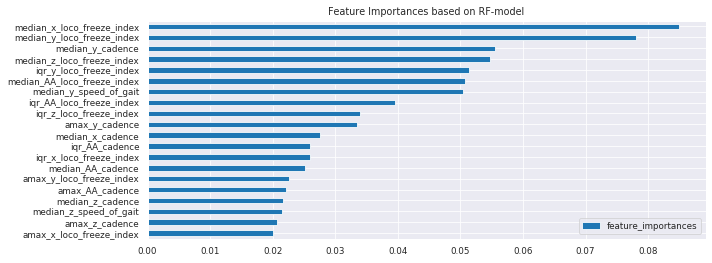

In [9]:
pd.DataFrame(data = model.feature_importances_, index = train.columns)\
.sort_values(0, ascending = True).tail(20).rename({0:"feature_importances"}, axis = 1).plot(kind = "barh", figsize = (10,4))
plt.title("Feature Importances based on RF-model")
plt.show()

As seen from the RF feature importances above, here are some features that performs really well on determining walking-balance data. Some key takeaways are that freeze indexes and speed of gait ranks consistently high up the feature importance list. And the features listed above are very practical to what is happening on user that is resting as a typical criteria of user that is resting is that they are more likely to have lower speed of gait, higher freeze index, and lower cadence. An ideal case of a group that is resting is also possessing signals that is not consistently fluctuating, whereas users that is actually walking would have more cyclical time series signals. 

### Refit to tests

In [10]:
# refit to test data for increasing samples
model.fit(X_test, y_test)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=100,
                       verbose=0, warm_start=False)

### Fitted Model on Passive Data

This part will explore how the fitted model performs on the passive data. The RF model will be used to predict a probability on the passive data, treating the prediction as an unsupervised learning model as we do not have any means of comparing our predictions to the any truth baseline. An ideal model prediction is that we would like to visualize the walking or balance probability and see whether those two are separable from each other. Afterwards, we would like have validity checks on records with high probability of balance, and see whether the model has picked up some signals.

In [11]:
passive_x_test = passive_data[feat_cols].drop(["healthCode"], axis = 1).set_index("recordId")
idx = passive_x_test.index

passive_y_test = passive_data["test_type"].map({"walking":1, "balance":0})
passive_x_test = pd.DataFrame(imp_median.transform(passive_x_test), index = idx)

# get probability dataframe
proba = pd.DataFrame({"probability_walking": model.predict_proba(passive_x_test)[:,1],
                     "probability_balance": model.predict_proba(passive_x_test)[:,0]}, index = idx)

### Probability Distribution of Model on Passive Data

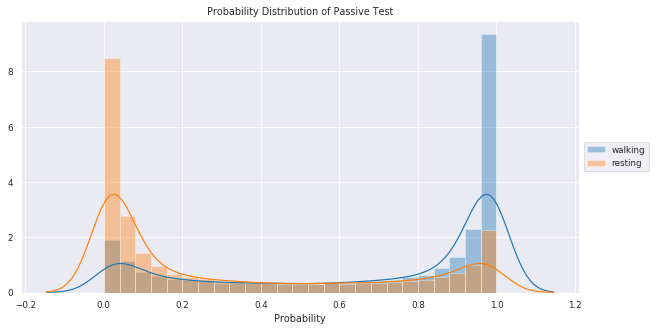

In [12]:
plt.figure(figsize = (10,5))
sns.distplot(proba["probability_walking"], label = "walking")
sns.distplot(proba["probability_balance"], label = "resting")
plt.xlabel("Probability")
plt.title("Probability Distribution of Passive Test")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

The distribution plot above show that there are two distinct spikes on the prediction probabilities on the two extremes of the passive gait data. Therefore we will check the propensity scores on the two extremes to see whether our model and features are actually capturing the right gait signals.

### Visualize Signal Data on Records with High Classification Scores

In [25]:
# retrieving RId
arr_rid_not_move   = list(proba["probability_balance"].sort_values(ascending = False).head(10).index)
arr_rid_move       = list(proba["probability_balance"].sort_values(ascending = False).tail(30).index)
arr_rid_borderline = list(proba[proba["probability_balance"] == 0.5].tail(10).index)

In [21]:
# Get all the paths
path_not_move_data = query.get_walking_synapse_table(syn,table_id = "syn17022539", table_version = "MPOWER_PASSIVE", 
                                recordIds = arr_rid_not_move) #move

path_move_data = query.get_walking_synapse_table(syn,table_id = "syn17022539", table_version = "MPOWER_PASSIVE", 
                                recordIds = arr_rid_move) #move

path_borderline_data = query.get_walking_synapse_table(syn,table_id = "syn17022539", table_version = "MPOWER_PASSIVE", 
                                recordIds = arr_rid_borderline) #move

# instantiate gaitFeaturize class for analysis
gf = gproc.GaitFeaturize()

Querying MPOWER_PASSIVE Data


KeyboardInterrupt: 

### Records with High Probability of Resting


###################### SAMPLE 1 ################################################
################################################################################


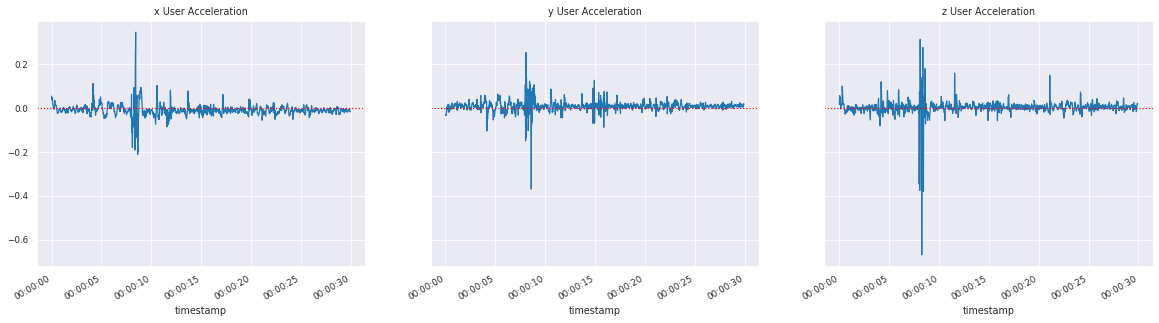

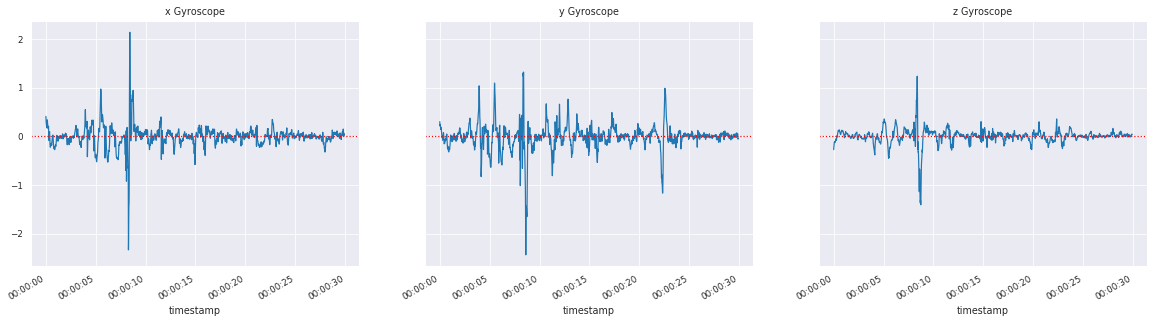


###################### SAMPLE 2 ################################################
################################################################################


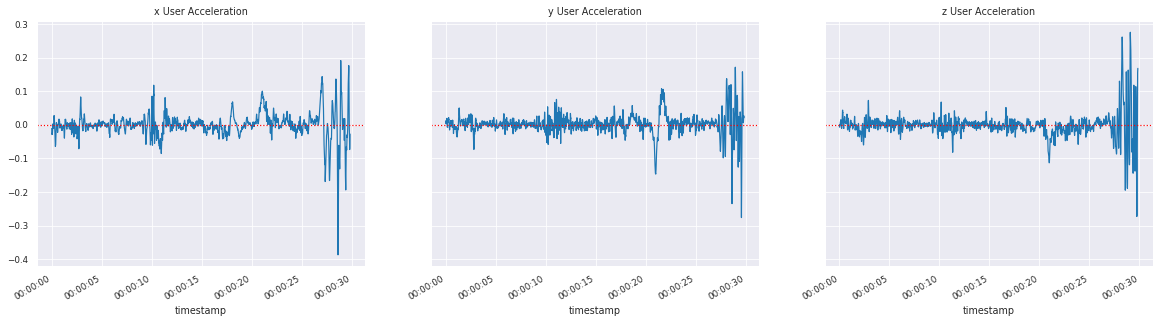

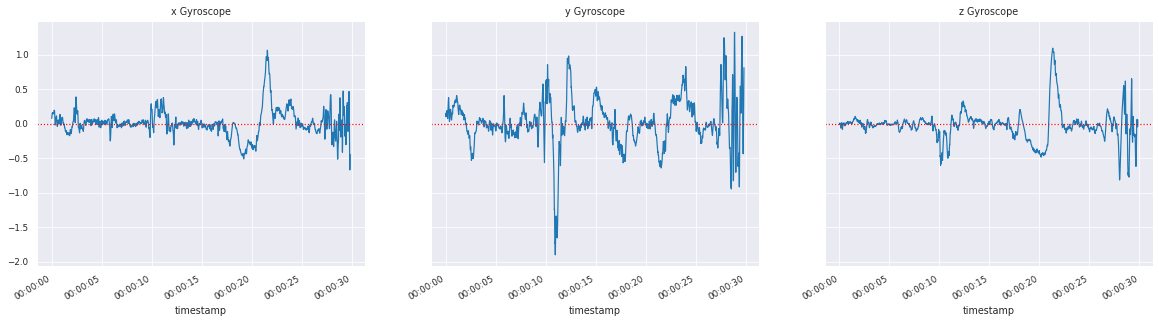


###################### SAMPLE 3 ################################################
################################################################################


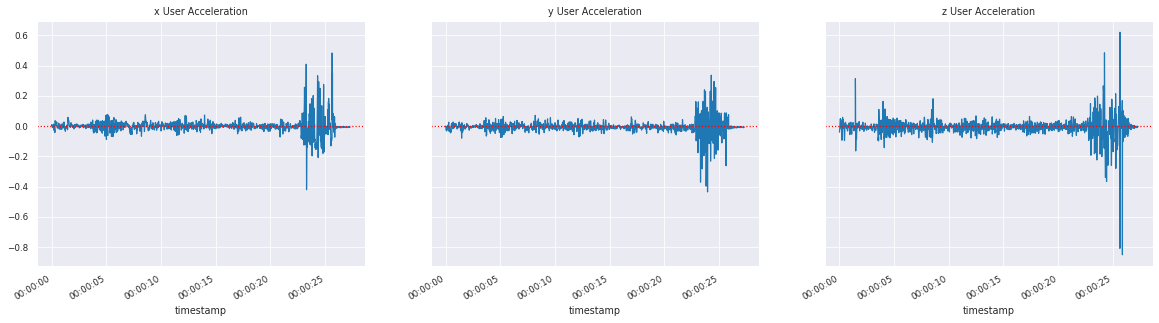

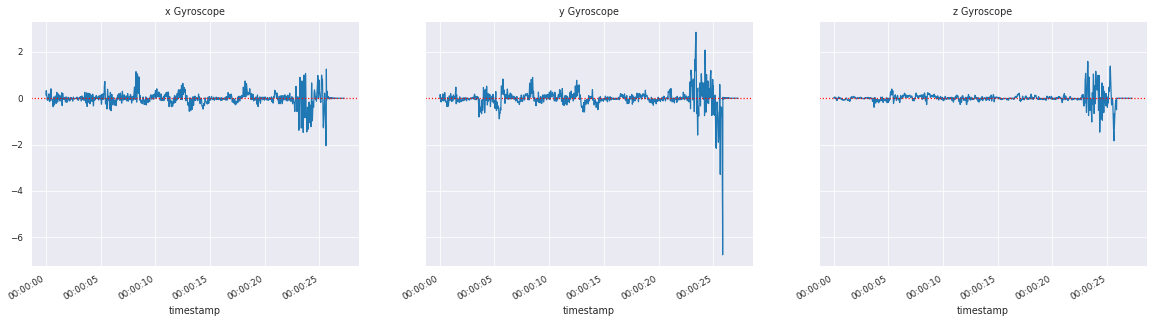


###################### SAMPLE 4 ################################################
################################################################################


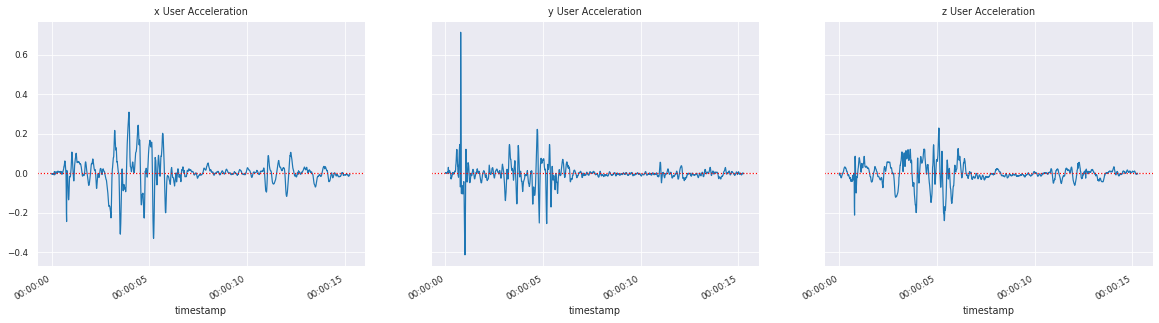

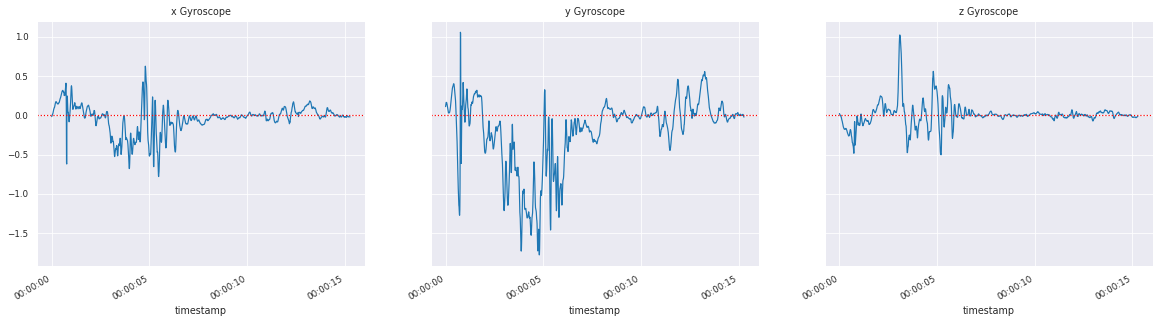


###################### SAMPLE 5 ################################################
################################################################################


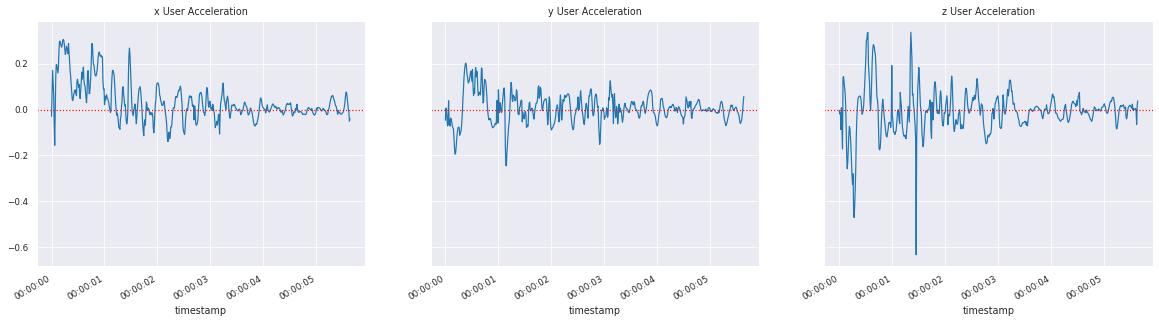

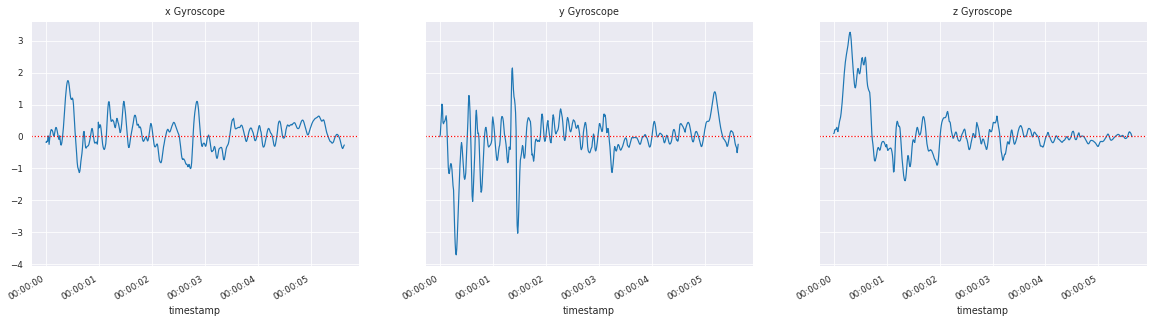

In [15]:
visualize_signal_helper(path_not_move_data.head(5))

Looking at our signal data on records that has very high probability of resting, note that the user acceleration data is only fluctuating on some period amount of time, then reverted back to white noise readings after several seconds. The gyroscope reading is also consistent to those signal in the user acceleration as it reverted back to the zero radian/seconds horizontal line and fluctuates as random white noise after several seconds. From the plot above, it is apparent that the users are not properly walking during the passive gait test. 

This occurences are likely to happen when user triggered the passive data collection, and rested immediately, which can happen due to the passive gait data collection that prompts to go back to sleep after zero displacement in some amount of time. 

### Records with High Probability of Walking

In [19]:
list(path_move_data["recordId"])

['7ebb0be2-6b6f-446d-8628-3924ab379009',
 '86d4c4aa-6be7-460a-a42d-e4d04d310828',
 '86d7ce54-bf29-4201-939a-eed34b2a838e',
 '86e1a850-0f57-4252-9af3-7407ae5c7ff7',
 '86e56869-b40a-4e84-88b7-8f2a3c2aca77',
 '87957f36-8368-4ec4-8544-5855944f74be',
 '88371b06-fb46-4f2f-b951-ca9b47a8eaca',
 '88a32be4-9f75-4ee1-87f1-324234980c45',
 '88d6d391-eac4-439c-b35f-d5de6a19f755',
 '89c5cdf2-83a2-4f8a-b1ac-5cc89c71ad3d']


###################### SAMPLE 1 ################################################
################################################################################


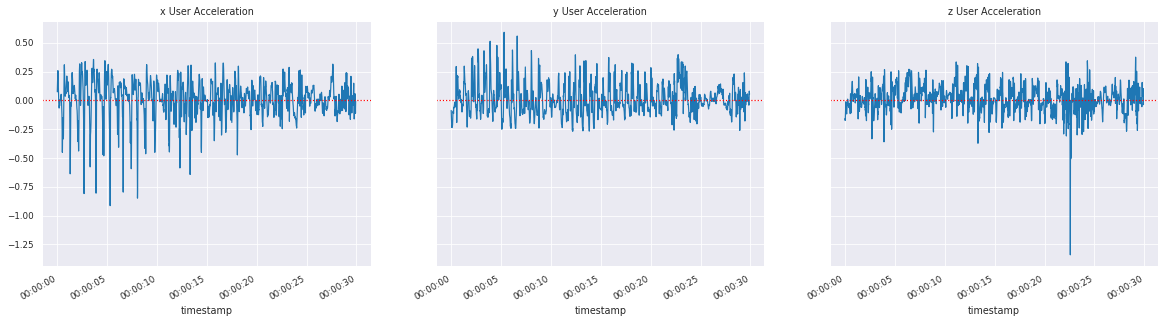

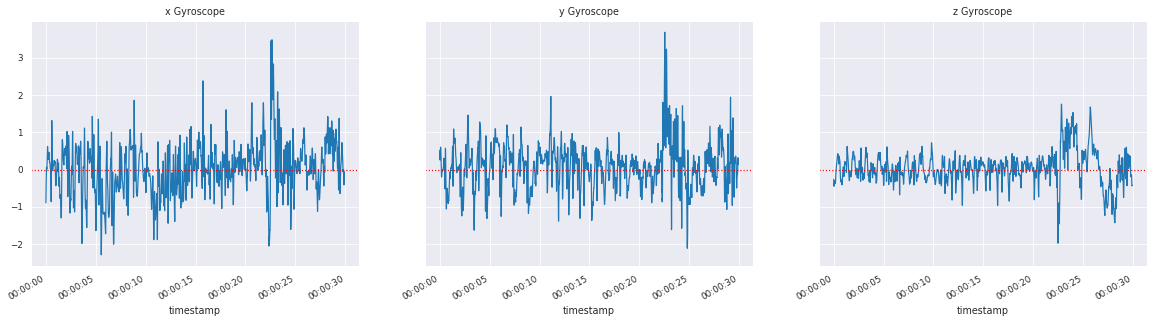


###################### SAMPLE 2 ################################################
################################################################################


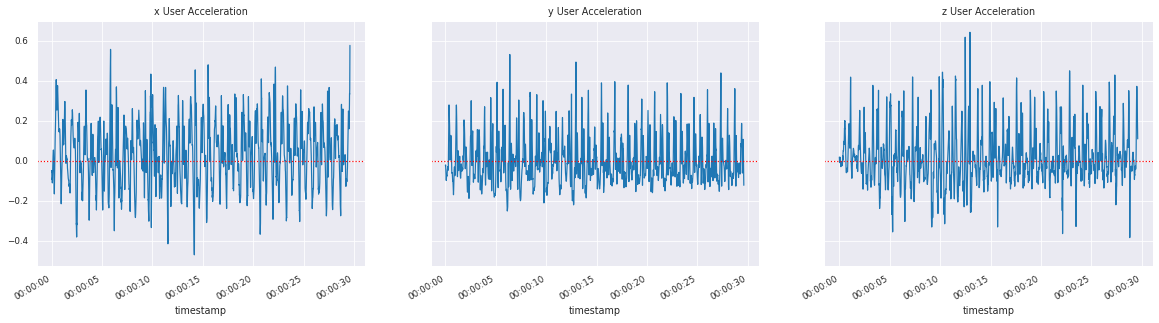

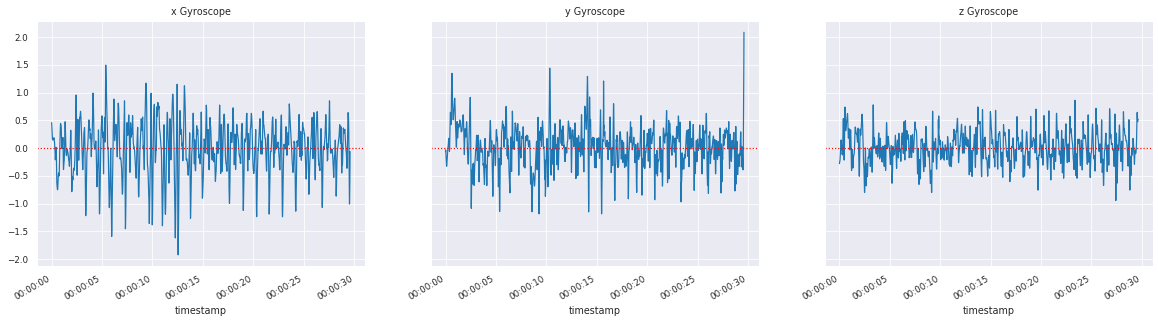


###################### SAMPLE 3 ################################################
################################################################################


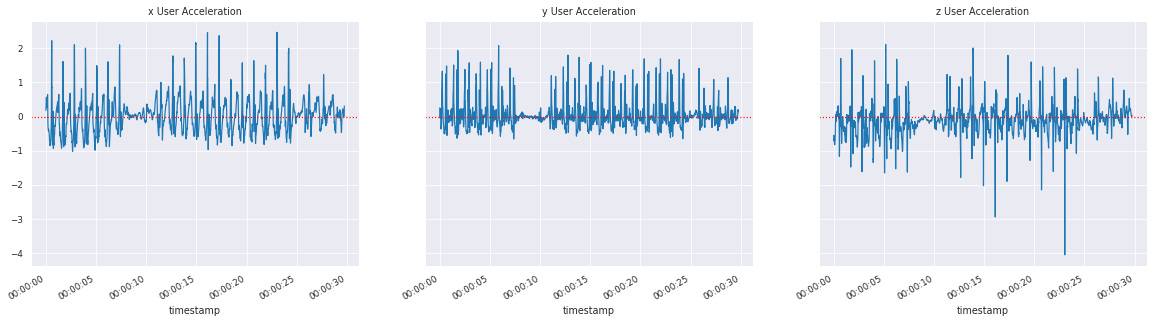

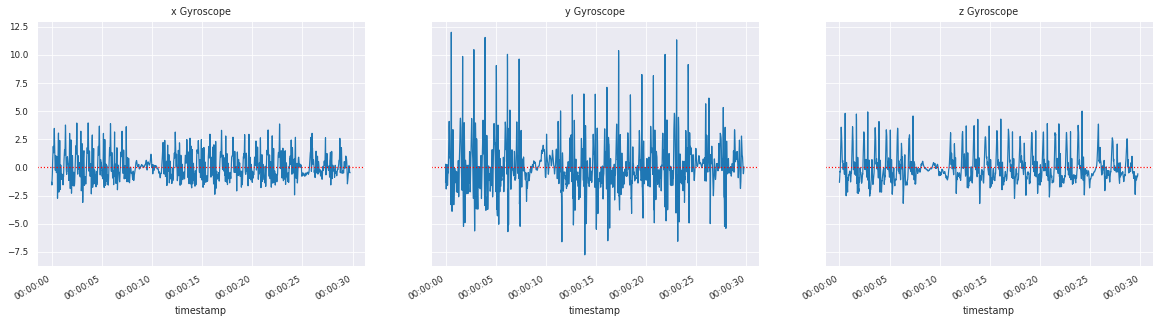


###################### SAMPLE 4 ################################################
################################################################################


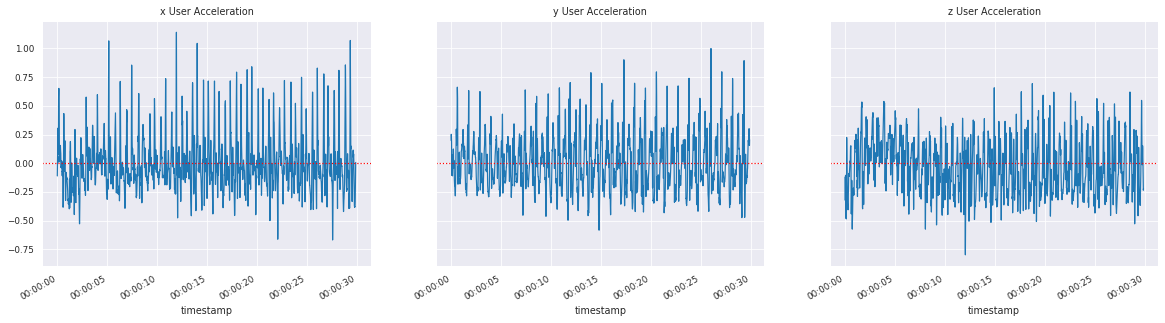

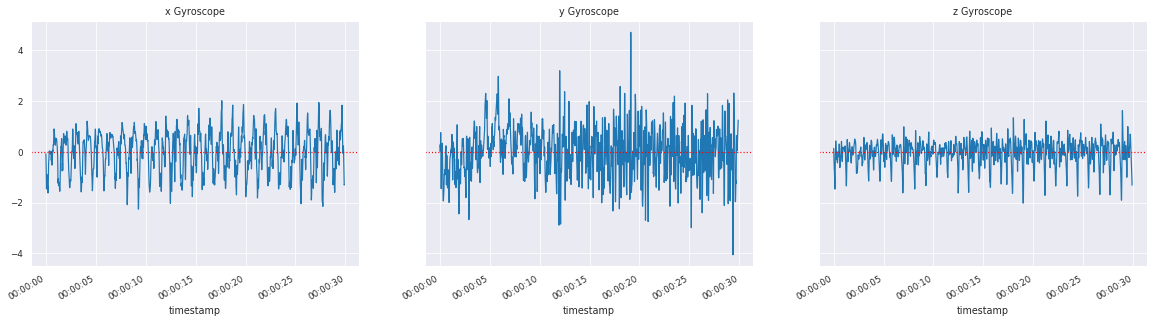


###################### SAMPLE 5 ################################################
################################################################################


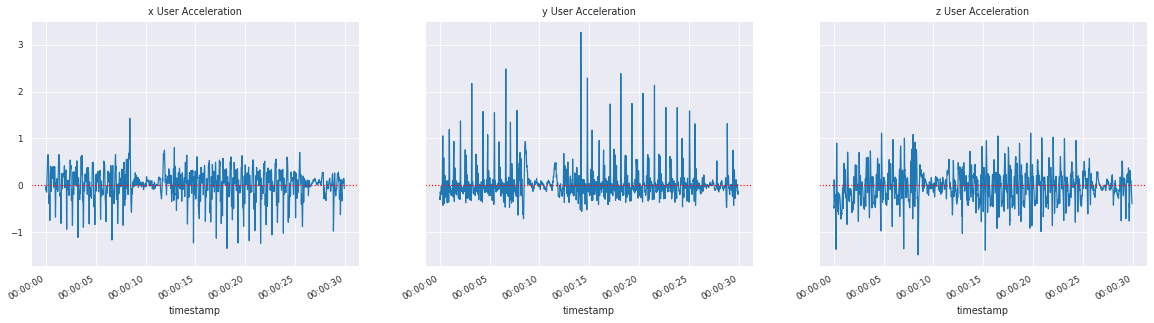

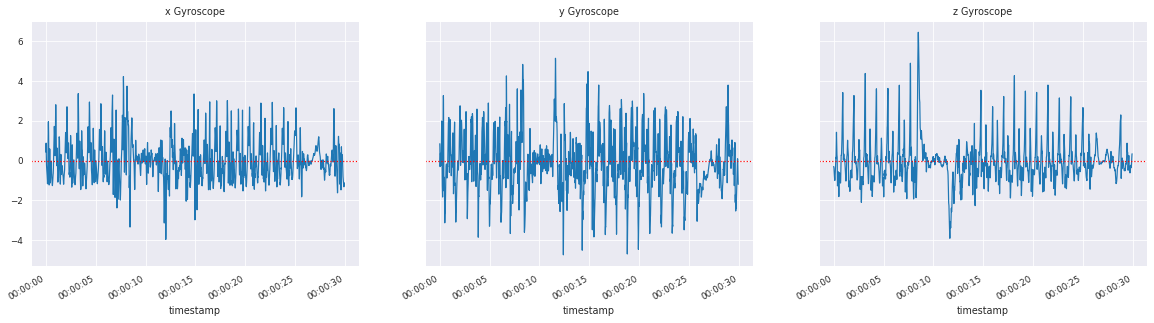

In [17]:
visualize_signal_helper(path_move_data.head(5))

Above is a plot of some subset of data that is predicted to have high probability of walking. When compared to the group that has high probability of resting, it is very notable that the plot above is far more fluctuative in both the collected gyroscope and the user acceleration signal data. Therefore we can say that the model are able to pickup signals that indicates whether a user is actually walking during the passive gait test.

### Records that have 50/50 probability


###################### SAMPLE 1 ################################################
################################################################################


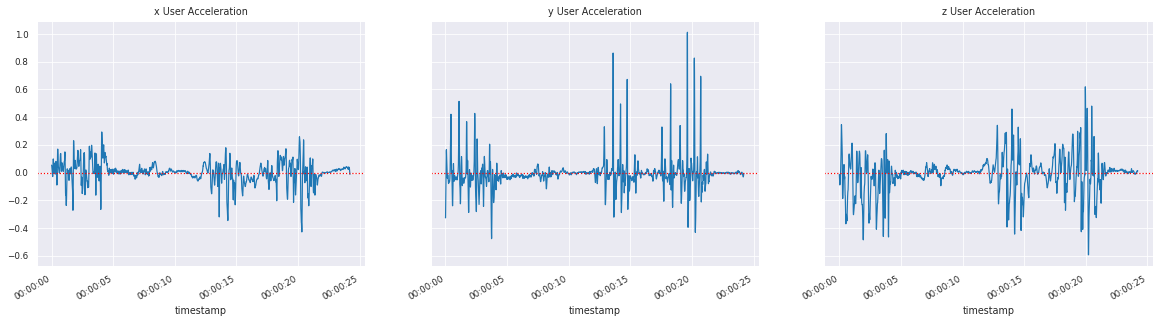

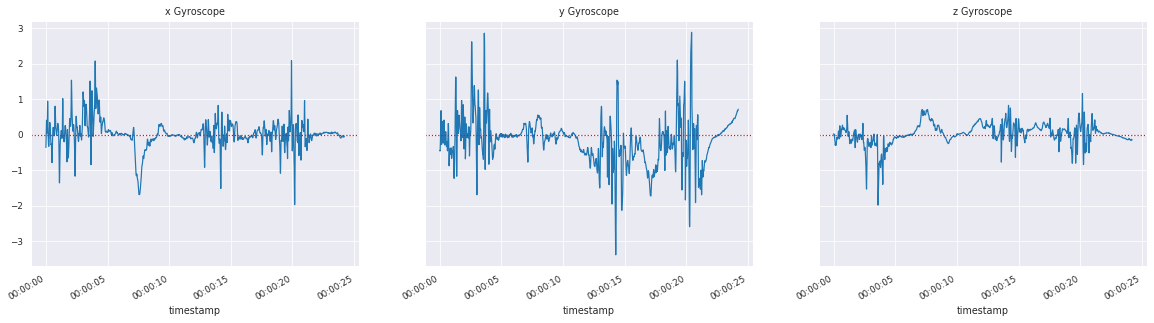


###################### SAMPLE 2 ################################################
################################################################################


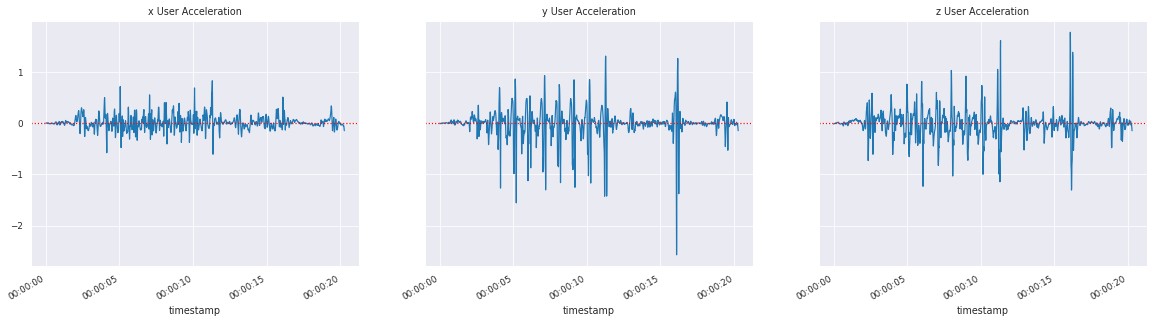

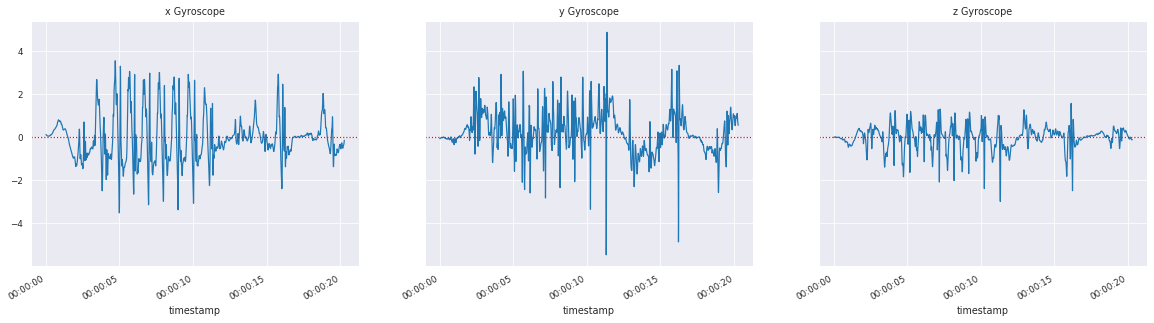


###################### SAMPLE 3 ################################################
################################################################################


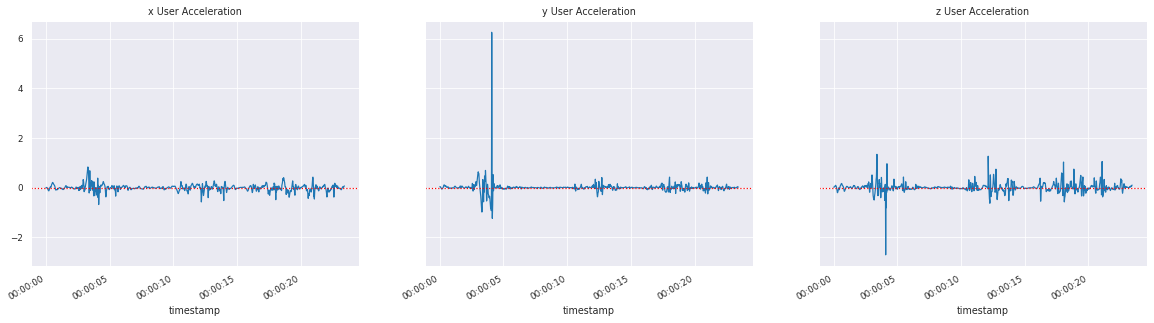

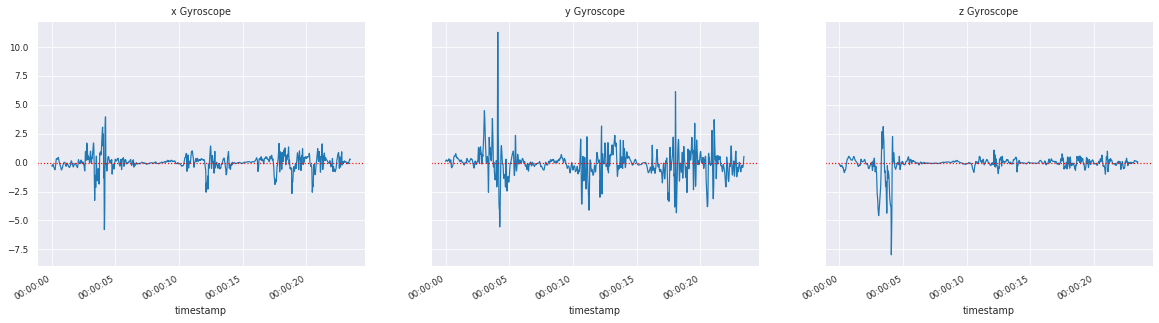


###################### SAMPLE 4 ################################################
################################################################################


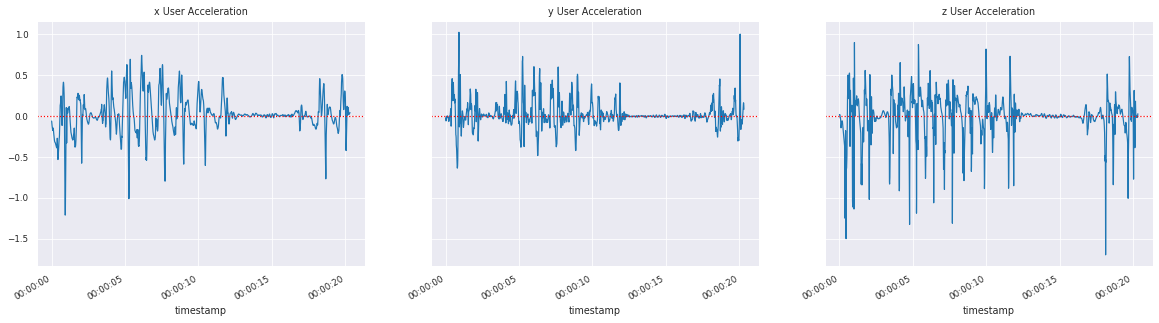

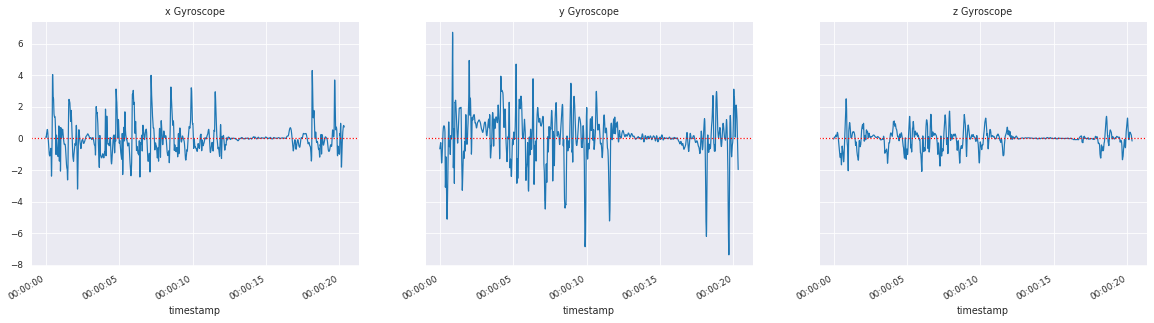


###################### SAMPLE 5 ################################################
################################################################################


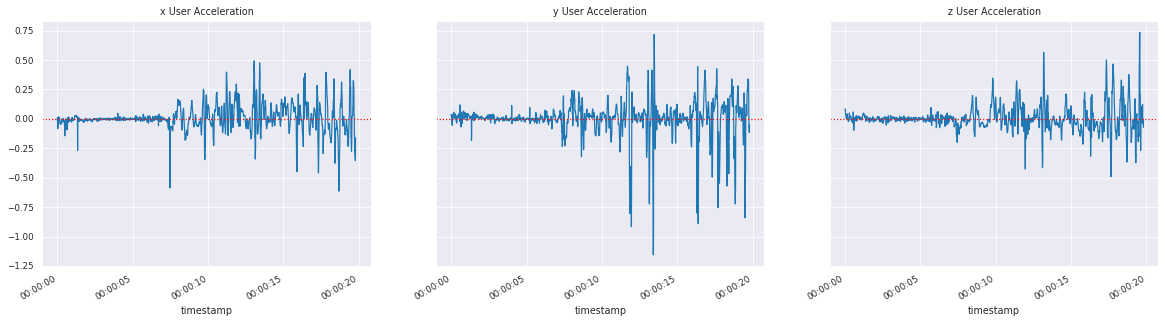

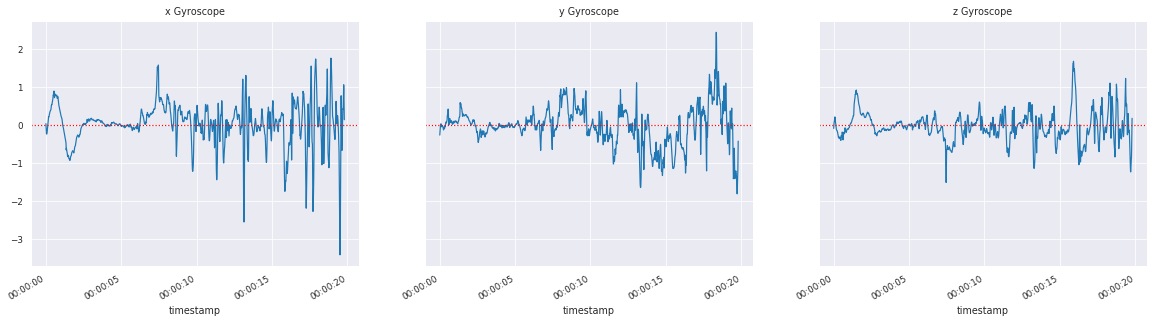

In [18]:
visualize_signal_helper(path_borderline_data.head(5))

## Results:

From the analysis above, we can see that the RF model fitted on the active walking-balance test do have the capability of separating walking data and non-walking data from the passive gait data. However, it is still not perfect as the data that ranges in the borderline threshold (0.5-0.5 on both propensity scores) the model is still incapable of recognizing obvious pattern on user that is not really doing the test, like the signal in sample 3. We have only tested one single model and have not tried any other models or any feature engineering on the data, which might be a subject of interest in the future. And since it is an unsupervised model, we have no way of validating all the results, especially to those recordIds that are misclassified. 

#### Future Work:
- Annotate for validation (maybe?)
- Try different models and see how it changes the feature importances
- Optimize probability distribution intersection between the walking and non-walking through better feature creation